# <span style="color:#00c5cd; font-size:34px;" >Airline predictor</span>
### <span style="color:#ff4444;">Þórhildur Þorleiksdóttir and Lea El Hage </span>
#### <span style="color:#ffb14c;">Artificial Intelligence And Applied Methods, 2017</span>

In [2]:
import matplotlib
#matplotlib.use('GTKAgg')

import matplotlib.pyplot as plt
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
from plotly.offline.offline import _plot_html
import plotly.graph_objs as go
import plotly.plotly as py

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

import pandas as pd


init_notebook_mode(connected=True)
%matplotlib inline
matplotlib.style.use('ggplot')

 



In [3]:
data = pd.read_csv('flights.csv', encoding='ISO-8859-1', usecols=[0,1,2,4,7,11,24], low_memory=False) #,25,26,27,28,29,30])
# Year0 | Month1 | Day2 | Airline4 | Origin_airport7 | Departure_delay11 | Cancelled24 | Cancellation_reason25 | Air_system_delay26 | Security_delay27 | Airline_delay28 | Late_Aircraft_delay29 | 
#Weather_delay30

In [4]:
#NOT WORKING READS FLIGHT INSTEAD OF AIRLINE

airline = pd.read_csv('airlines.csv',  usecols=[0,1], low_memory=False)
airline_data = airline.rename(columns={'IATA_CODE':'code','AIRLINE':'airline'})
airline_data



,code,airline
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [5]:
flight_data = data.rename(columns={'YEAR':'year','MONTH':'month','DAY':'day',
                                   'AIRLINE':'airline','ORIGIN_AIRPORT':'airport','DEPARTURE_DELAY':'delay', 
                                   'CANCELLED':'cancelled'})


flight_data['date'] = pd.to_datetime(flight_data[['year','month','day']]).dt.date

flight_data['delay'] = (flight_data['delay'] > 0).astype(int)

In [6]:
#Total flight per month

flight_data['count'] = 0
flights_per_month = flight_data.groupby(['month'])['count'].count().to_frame()

In [7]:
#Delayed flights per month

flight_data_delays = flight_data[(flight_data.delay == 1)]
delayed_flights_per_month = flight_data_delays.groupby(['month'])['count'].count().to_frame()
delayed_flights_per_month = delayed_flights_per_month.rename(columns={'count':'d_count'})

In [8]:
#Cancelation of flights per month

flight_data_cancelation = flight_data[(flight_data.cancelled == 1)]
cancelled_flights_per_month = flight_data_cancelation.groupby(['month'])['count'].count().to_frame()
cancelled_flights_per_month = cancelled_flights_per_month.rename(columns={'count':'c_count'})


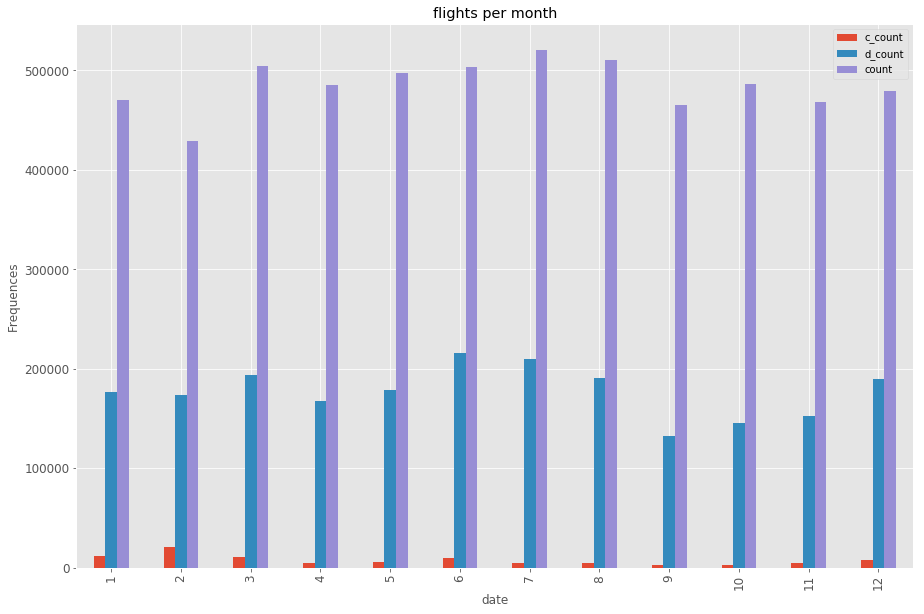

In [9]:
#Mergin the dataframes on date for the plot

merged_frame = pd.concat([flights_per_month, delayed_flights_per_month, cancelled_flights_per_month], axis=1)

ax = merged_frame[['c_count','d_count','count']].plot(kind='bar', title='flights per month', figsize=(15,10),fontsize=12)
ax.set_xlabel('date', fontsize=12)
ax.set_ylabel('Frequences', fontsize=12)
plt.show()



In [10]:
flights_per_month

,count
month,
1,469968
2,429191
3,504312
4,485151
5,496993
6,503897
7,520718
8,510536
9,464946


This pie chart represents the Flights delay grouped by airline. This will allow us to visualize which airline causes 
the most delay. This is done by taking our flight data delay table and joining it with the table airline to get more information about the flights.
From the results we can see that WN has the most delay which is predictable since the airline has the most flights in total. Then DL and UA are next.


In [11]:
flights_per_airline = flight_data_delays.groupby(['airline'])['count'].count().to_frame()
flights_per_airline = flights_per_airline.rename(columns={'count':'total_delay'})

flights_per_airline

values = flights_per_airline['total_delay'].tolist()
labels = flights_per_airline.index.tolist()

total_d =0
for i in values:
    total_d = i + total_d
    
total_ratio = [round(i / total_d * 100, 2) for i in values]


fig = {
    'data': [{'labels': labels,
              'values': total_ratio,
              'type': 'pie',
              'hoverinfo':'label+percent',
             }],

    'layout': {'title': 'Pie chart of the delays per airline'}
     }

iplot(fig)



This pie chart represents the Flights cancelled grouped by airline. This will allow us to visualize which airline causes the most cancelation. This is done by taking our flight data cancelation table and joining it with the table airline to get more information about the flights. From the results we can see that WN has the most cancelation which is predictable since the airline has the most flights in total. Then EV and MQ are next.

In [12]:
airline_cancel = flight_data_cancelation.groupby(['airline'])['count'].count().to_frame()

values = airline_cancel['count'].tolist()
labels = airline_cancel.index.tolist()

total_c =0
for i in values:
    total_c = i + total_c
    
total_ratio = [round(i / total_c * 100, 2) for i in values]

fig = {
    'data': [{'labels': labels,
              'values': total_ratio,
              'type': 'pie',
              'hoverinfo':'label+percent',
             }],

    'layout': {'title': 'Pie chart of the cancelation per airline'}
     }

iplot(fig)

In [13]:
#If Gustav wants to travel in august from LAX what airline should he use to reduce the chances of delay
#We shall use the month of july to train 
#Using naive bayes algorithm

#all flight from the LAX airport and removed columns that are uncessary
flight_LAX = flight_data[(flight_data.airport == "LAX")]
flight_LAX = flight_LAX.drop(['year', 'date','count','airport'], 1)

#train with the month of july
flight_LAX_july = flight_LAX[(flight_LAX.month == 7)]
flight_LAX_july = flight_LAX_july.drop(['month'], 1)

X_train = flight_LAX_july.day.values
Y_train = flight_LAX_july.delay.values

#test with the month of august 
flight_LAX_august = flight_LAX[(flight_LAX.month == 8)]
flight_LAX_august = flight_LAX_august.drop(['month'], 1)

X_test=flight_LAX_august.airline.values

clf = GaussianNB()
clf.fit(X_train, Y_train)


ValueError: Expected 2D array, got 1D array instead:
array=[ 1  1  1 ..., 31 31 31].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.